In [11]:
import os
import pygmt
import numpy as np
import xarray as xr
import rioxarray
import pandas as pd
from scipy import spatial
import matplotlib
import matplotlib.pyplot as plt
import cmocean

label_size = 7
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size
matplotlib.rc('font', size=6)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%config InlineBackend.figure_format = 'svg' # Uncomment this one for high resolution figs
%matplotlib inline

## Loading simulation results

In [57]:
out_path = 'export'

nc = os.path.join(out_path, "data18.nc")

dt = 200000
times = np.arange(-15.6e6,-12.0e6+dt,dt)

In [58]:
ds = xr.open_dataset(nc, decode_times=False)

## Offshore deposition

In [76]:
def plot_erodep(ds, step, box=None):
    
    fig = pygmt.Figure()
    with pygmt.config(FONT='8p,Helvetica,black',COLOR_FOREGROUND="red", COLOR_BACKGROUND="blue"):
        pygmt.makecpt(cmap="polar", series=[-2500,2500, 100]) 

        fig.basemap(
            region=[1.e6,5.e6,5e4,3.45e6],
            frame=['a'],
            projection="X15c/12.75c",
        )
        fig.grdimage(ds.erodep, shading=True, frame=False)
        fig.grdcontour(interval=0.1, grid=ds.elevation, limit=[-0.0001, 0.0001], pen='1.p')
        fig.colorbar(frame=["a500", "x+lErosion/Deposition", "y+lm"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #JMR+o0.5c/0c+w8c")
        if box is not None:
            fig.plot(data=np.array([[box[0],box[1],box[2],box[3]]]), style='r+s', pen="3p,black")
        # Customising the font style
        fig.text(text="Step "+str(step), position="TL", font="8p,Helvetica-Bold,black", xshift="-1.2c")

    fig.show(dpi=500, width=500)
    return

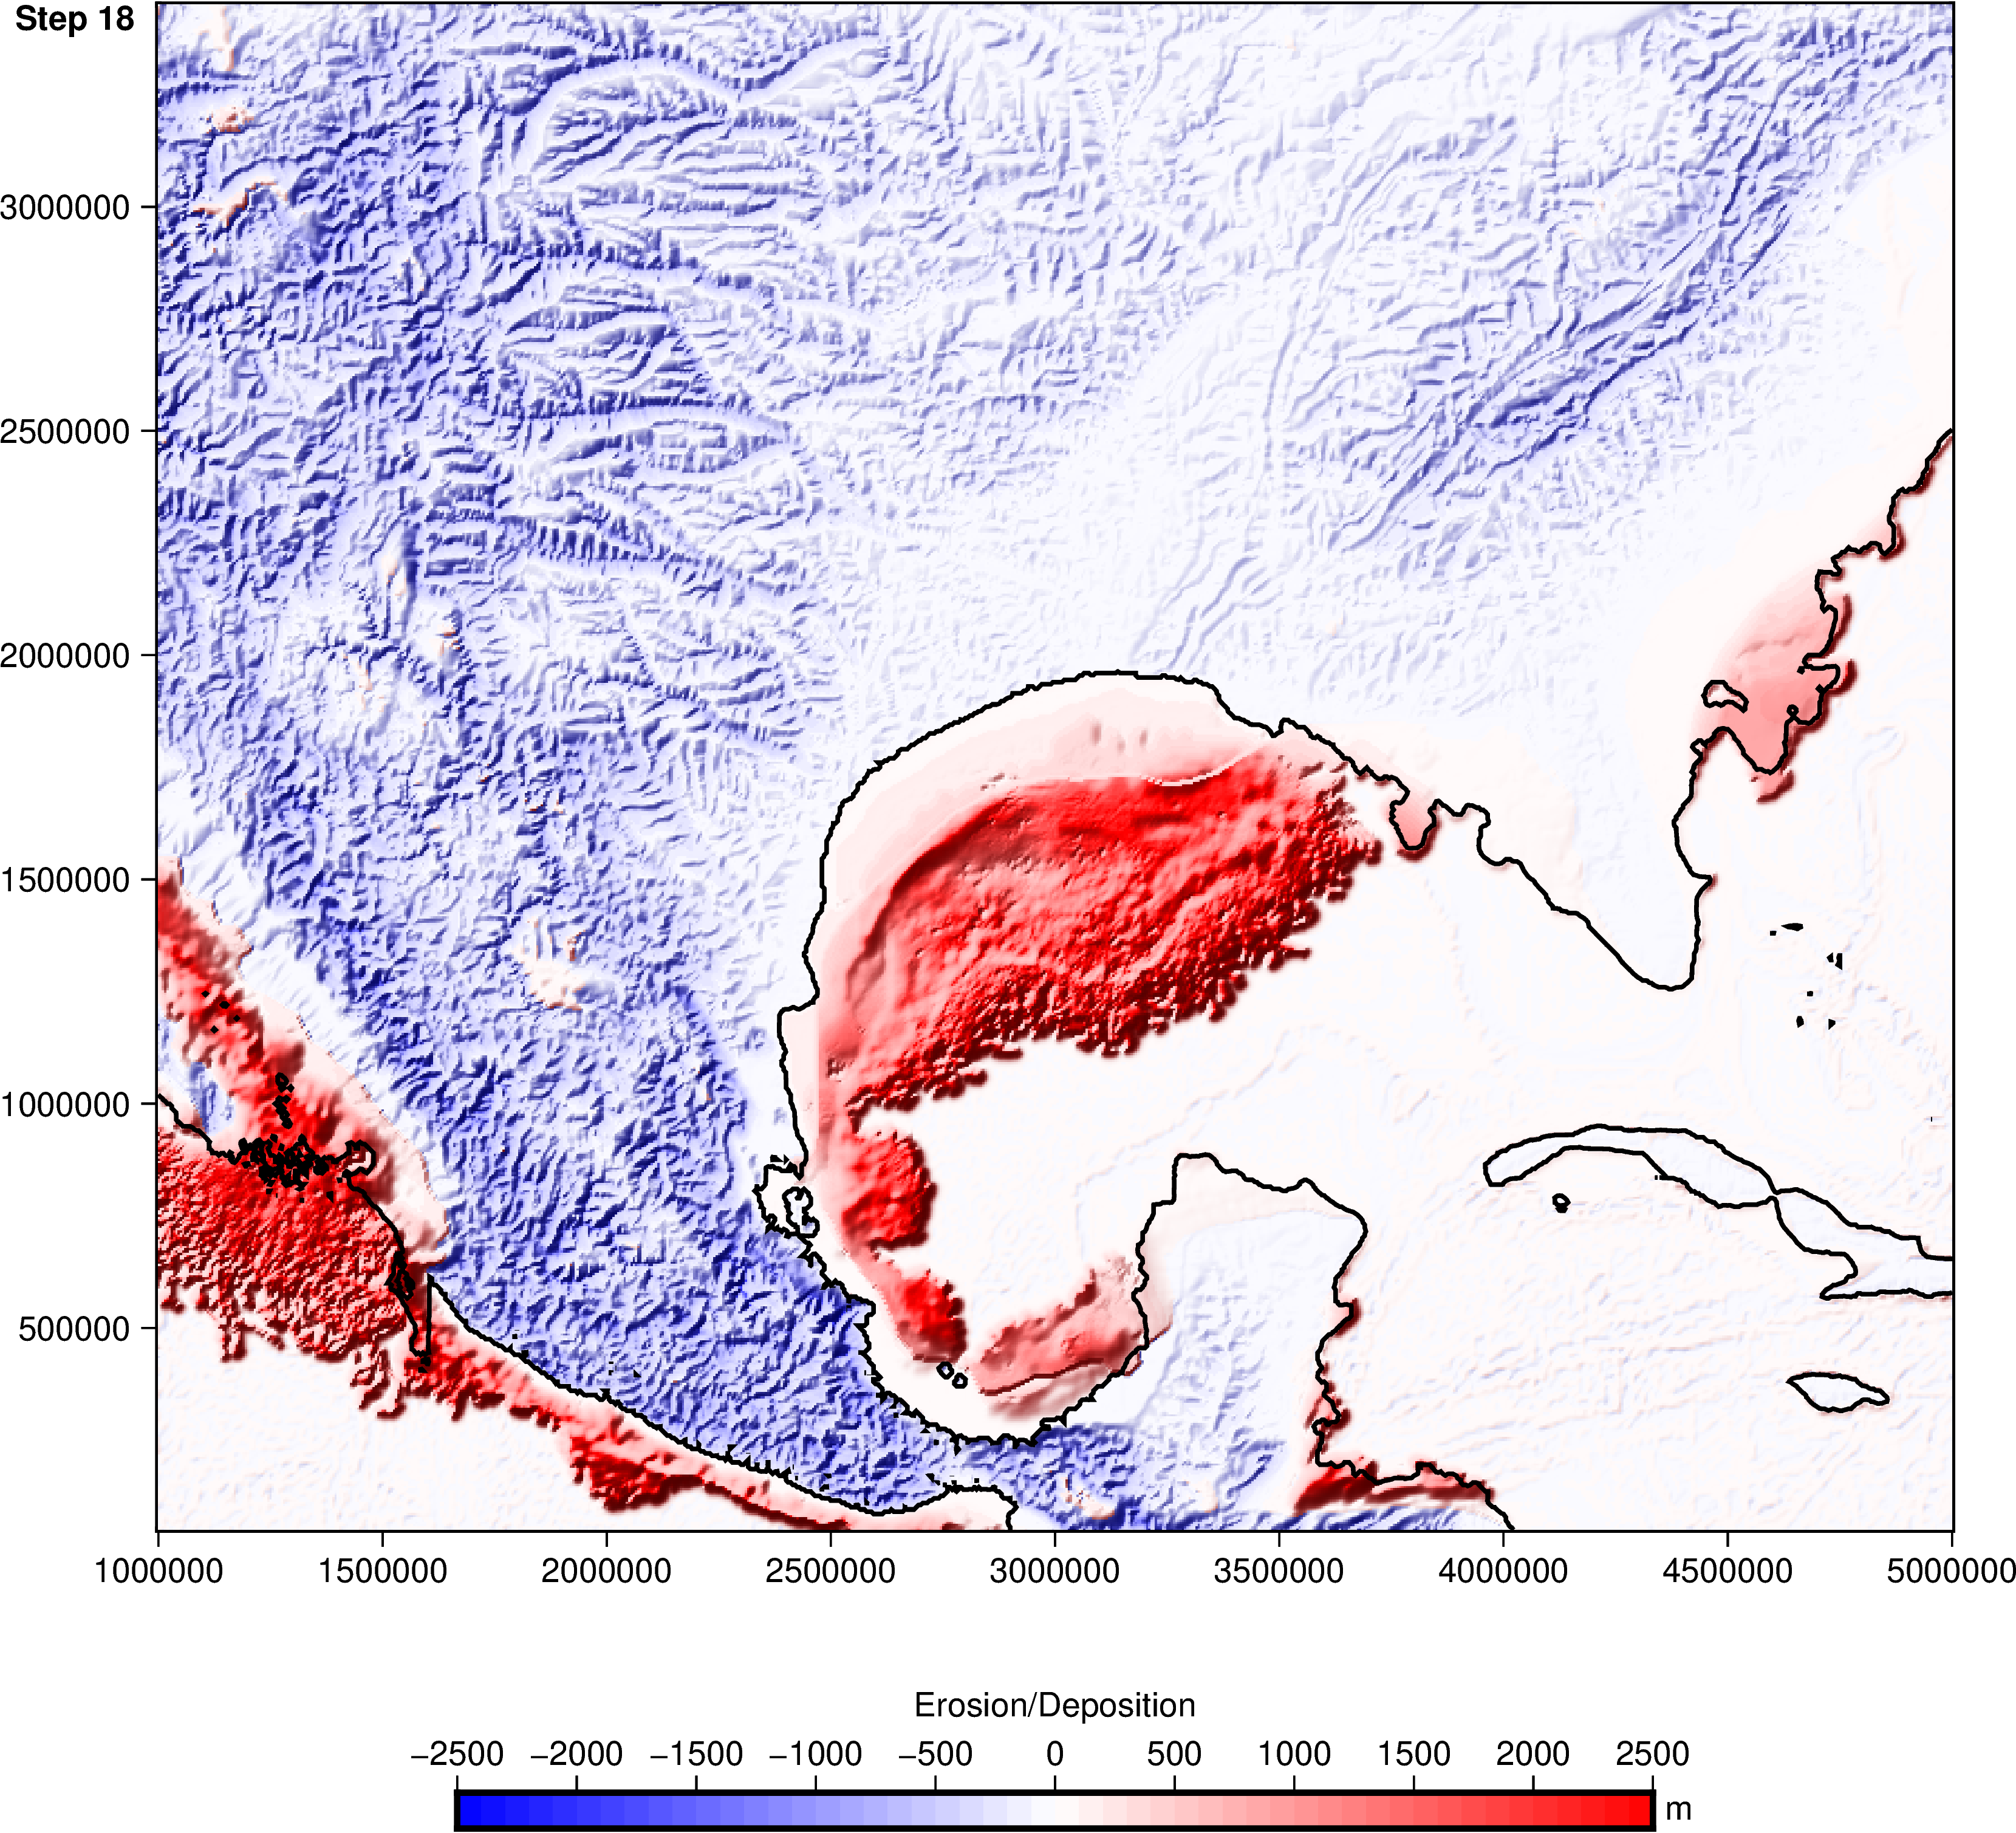

In [77]:
plot_erodep(ds, len(times)-1)

We will now pick a region of interest:

In [78]:
min_x = 2.5e6     # lower left x corner
min_y = 1.0e6       # lower left y corner
max_x = 3.5e6       # upper right x corner
max_y = 1.75e6       # upper right y corner

# Defining the boundaries
x_bnds = [min_x, max_x]
y_bnds = [min_y, max_y]

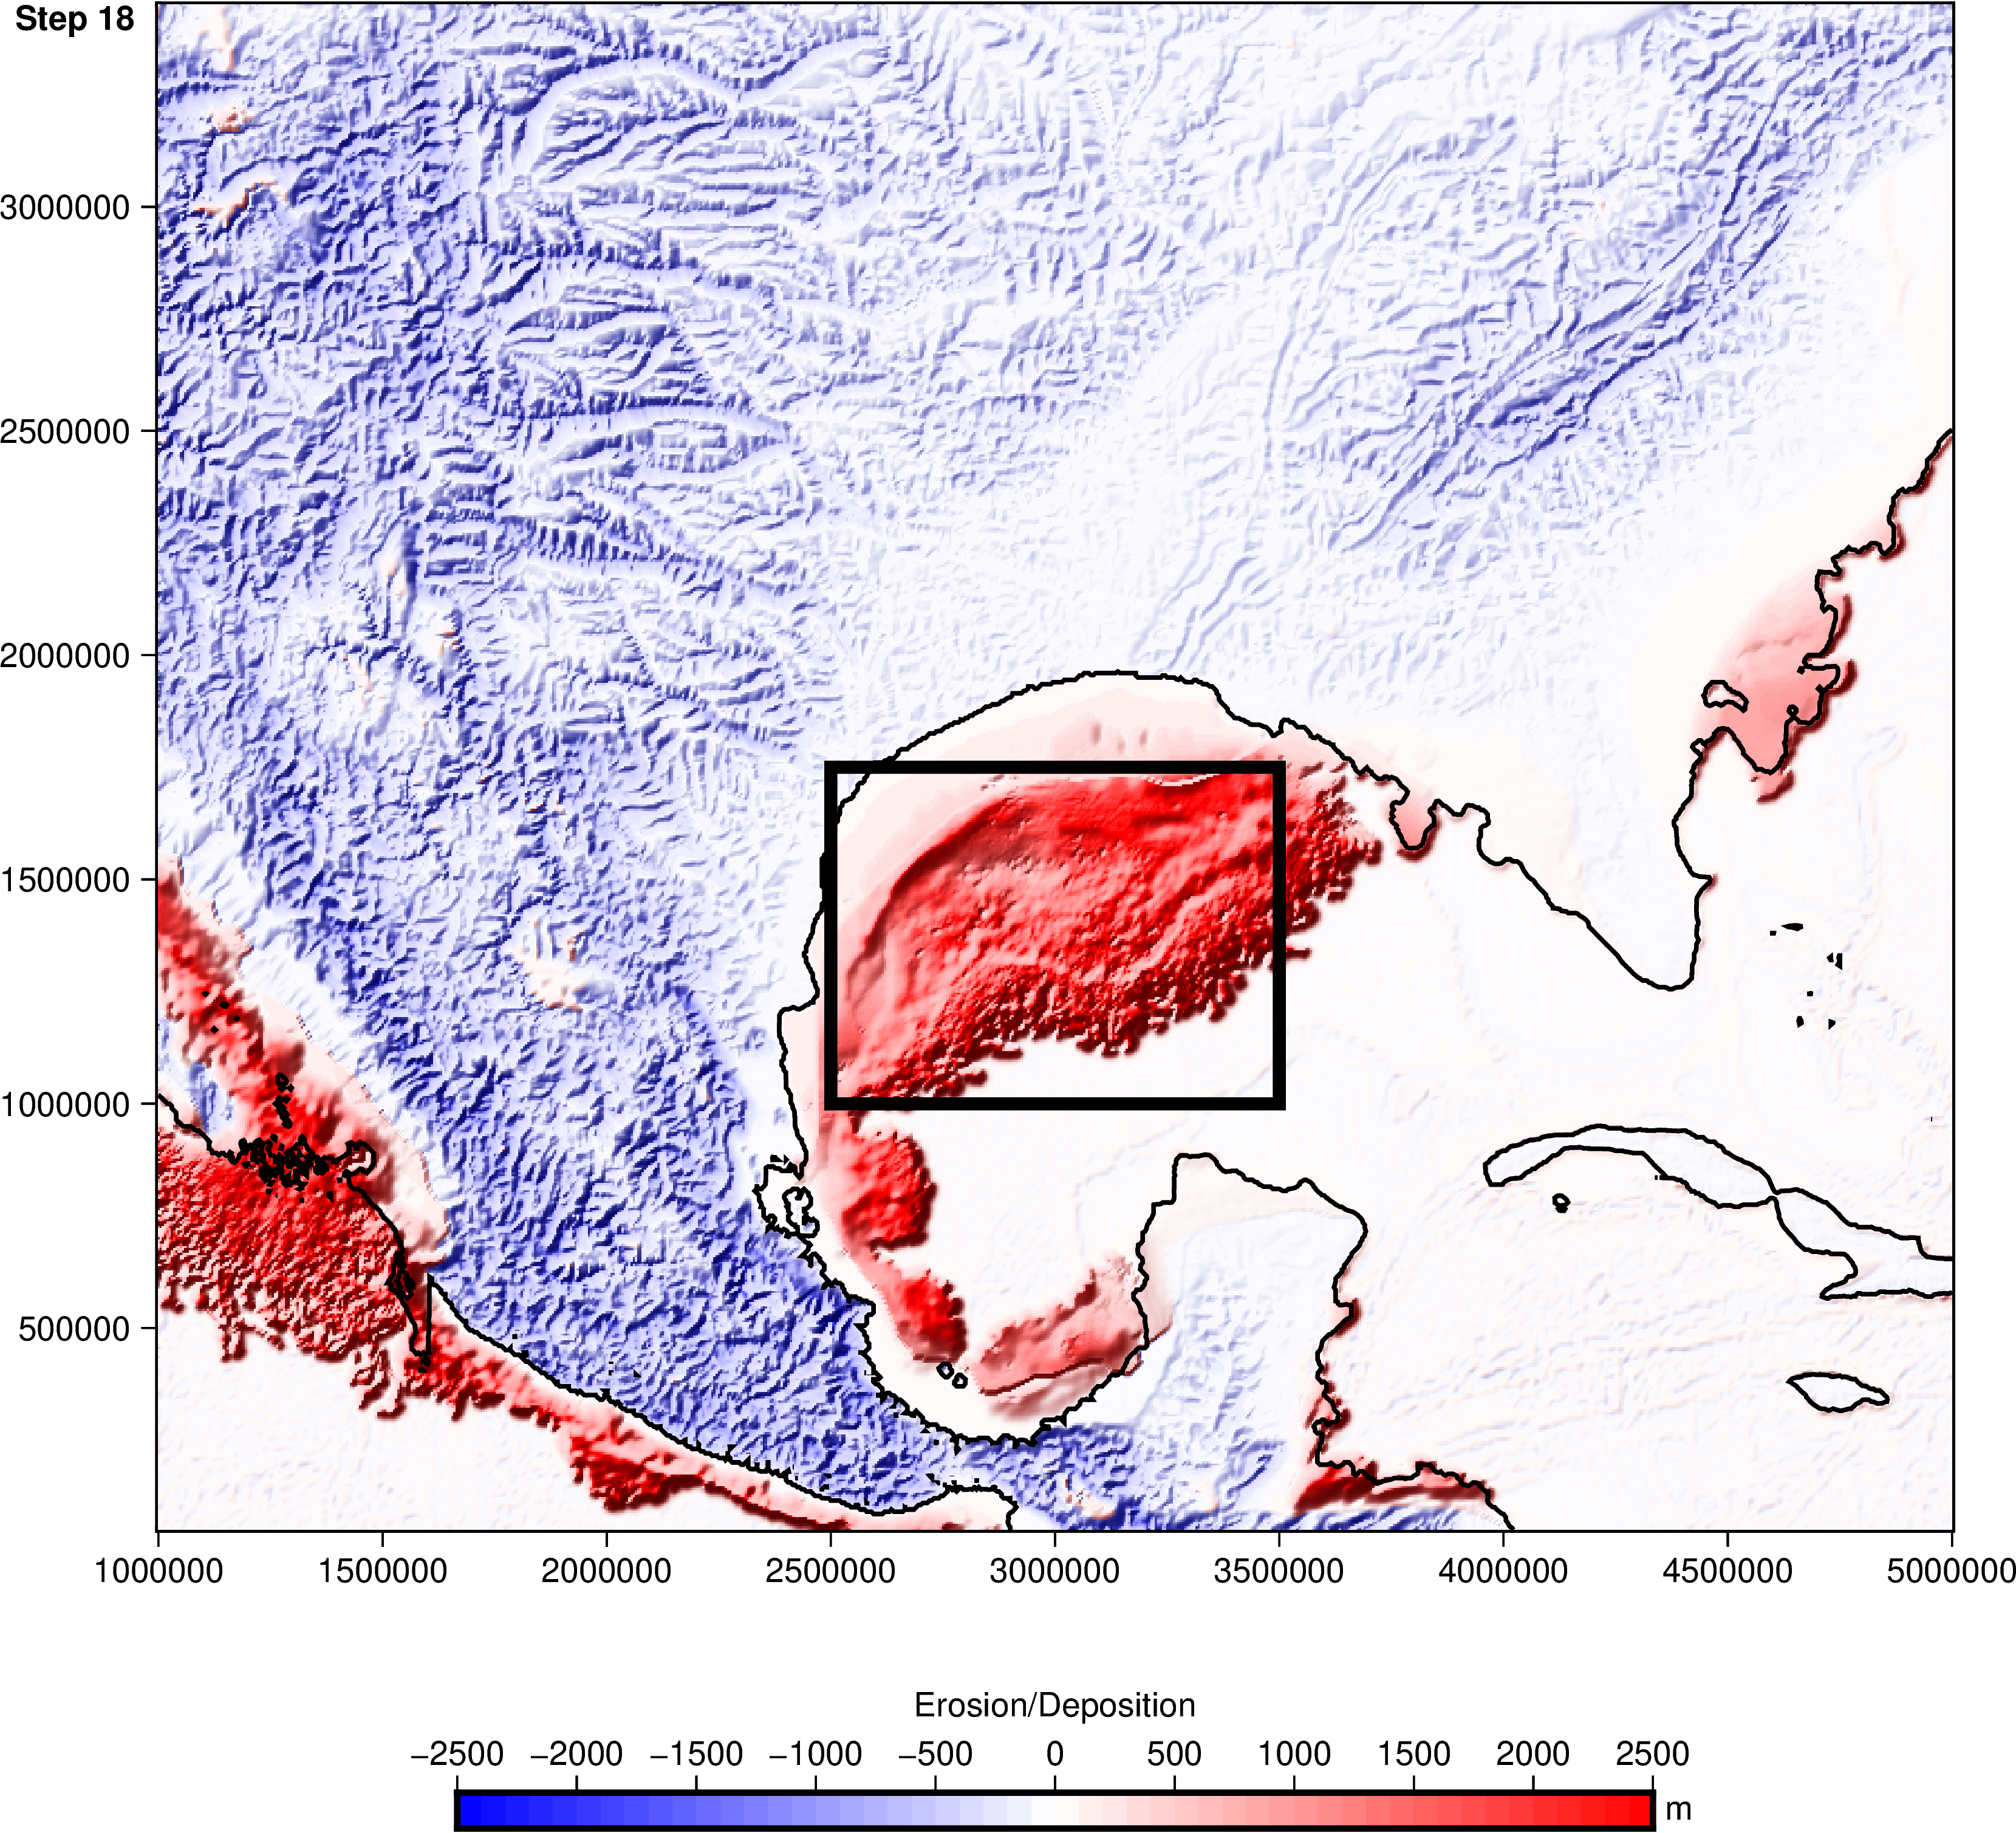

In [79]:
plot_erodep(ds, len(times)-1, box=[min_x, min_y, max_x, max_y])

Cumulative deposition in the region of interest

In [80]:
def cum_deposition(ncfile, nb, x_bnds,y_bnds ):
    
    dx = 0.
    deposum = []
    for k in range(nb):
        nc = ncfile+str(int(k))+'.nc'
        ds = xr.open_dataset(nc, decode_times=False)
        ds_clip = ds.sel(x=slice(*x_bnds), y=slice(*y_bnds))
        if dx == 0:
            dx = ds_clip.x.values[1]-ds_clip.x.values[0]
            dx2 = dx**2
        depo = ds_clip.erodep.where(ds_clip.erodep>0., 0)
        deposum.append(depo.sum().values.item()*dx2*1.e-9*1.e-3)
    
    return deposum

ncfile = out_path+'/data'
voldepo = cum_deposition(ncfile, len(times), x_bnds, y_bnds)

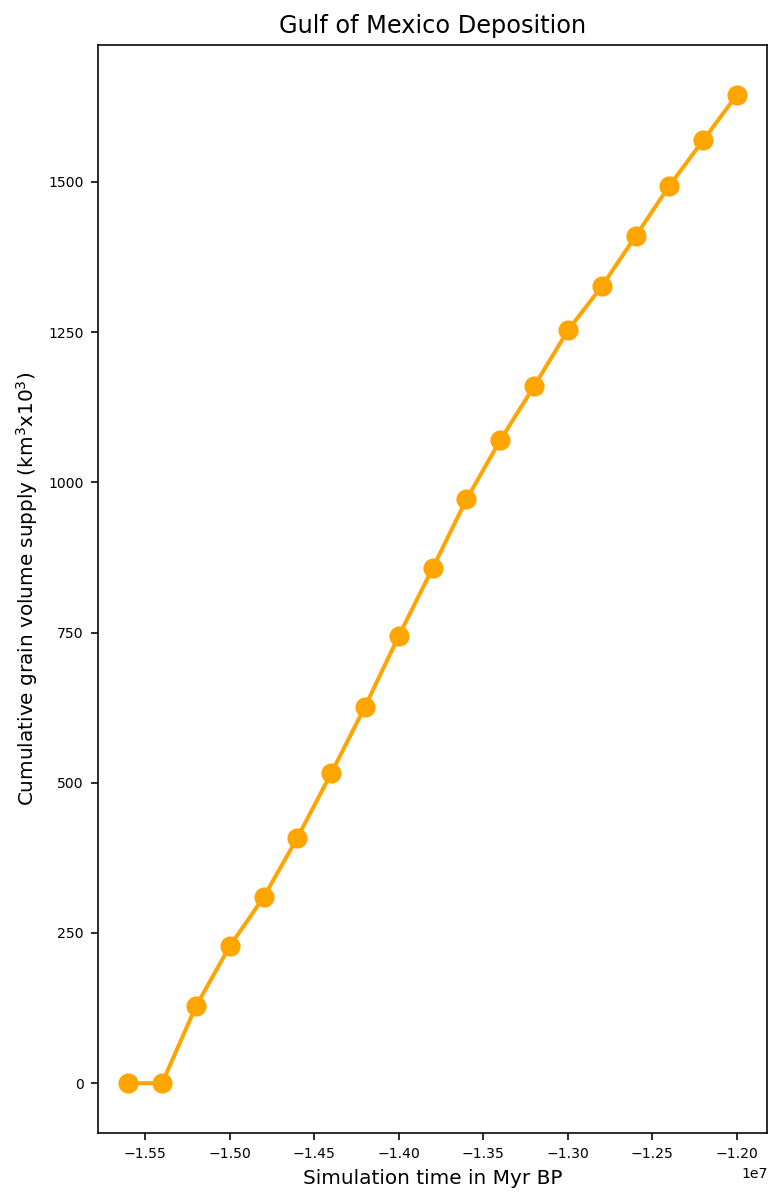

In [92]:
plt.figure(figsize=(6,10))

plt.xlabel('Simulation time in Myr BP')
plt.ylabel('Cumulative grain volume supply (km$^3$x10$^3$)')
plt.title('Gulf of Mexico Deposition')


# 1k
plt.scatter(times, voldepo,  s=50,  marker='o', facecolor='orange', lw = 3) #, label='dt=18')
plt.plot(times, voldepo,'orange',linewidth=2)

# plt.legend(loc=0, fontsize=10)

plt.show()
plt.close()

## Continental evolution

In [82]:
min_x = 1.5e6       # lower left x corner
min_y = 2.0e6       # lower left y corner
max_x = 2.5e6       # upper right x corner
max_y = 3.0e6       # upper right y corner

# Defining the boundaries
x_bnds = [min_x, max_x]
y_bnds = [min_y, max_y]

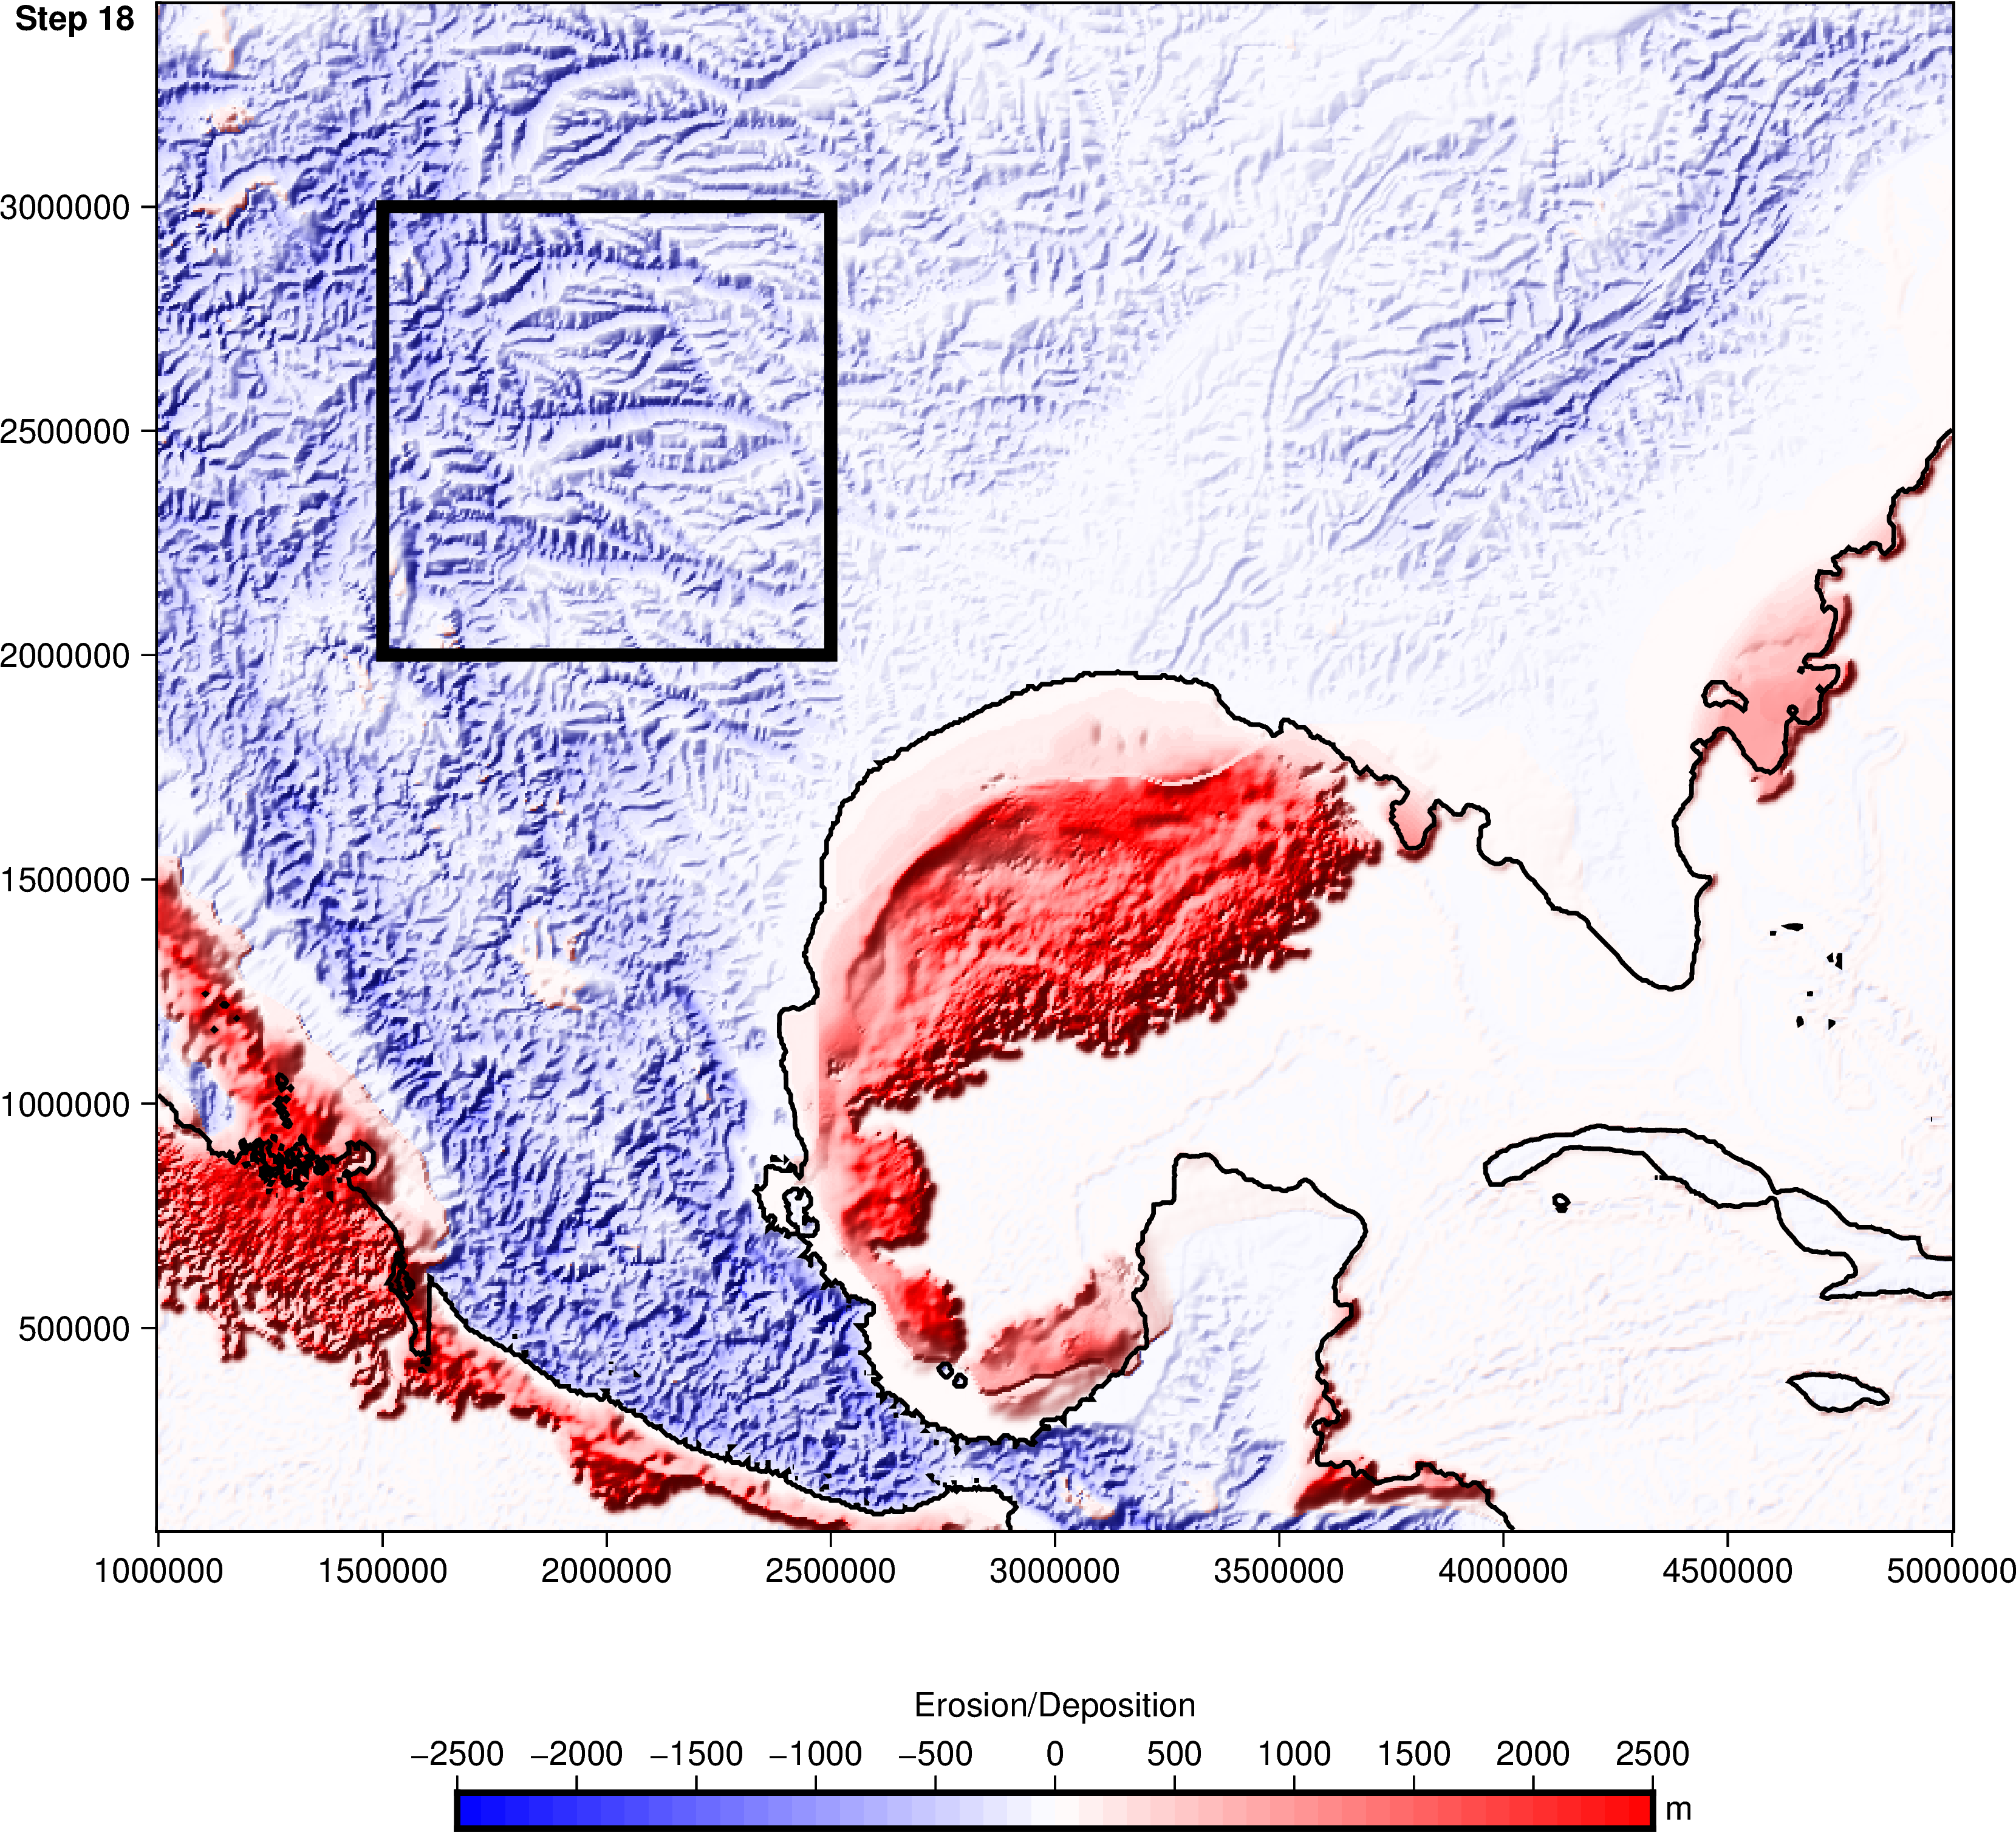

In [83]:
plot_erodep(ds, len(times)-1, box=[min_x, min_y, max_x, max_y])

In [85]:
def cum_erosion(ncfile, nb, x_bnds,y_bnds ):
    
    dx = 0.
    erosum = []
    for k in range(nb):
        nc = ncfile+str(int(k))+'.nc'
        ds = xr.open_dataset(nc, decode_times=False)
        ds_clip = ds.sel(x=slice(*x_bnds), y=slice(*y_bnds))
        if dx == 0:
            dx = ds_clip.x.values[1]-ds_clip.x.values[0]
            dx2 = dx**2
        ero = ds_clip.erodep.where(ds_clip.erodep<0., 0)
        erosum.append(-ero.sum().values.item()*dx2*1.e-9*1.e-3)
    
    return erosum

ncfile = out_path+'/data'
volero = cum_erosion(ncfile, len(times), x_bnds, y_bnds)

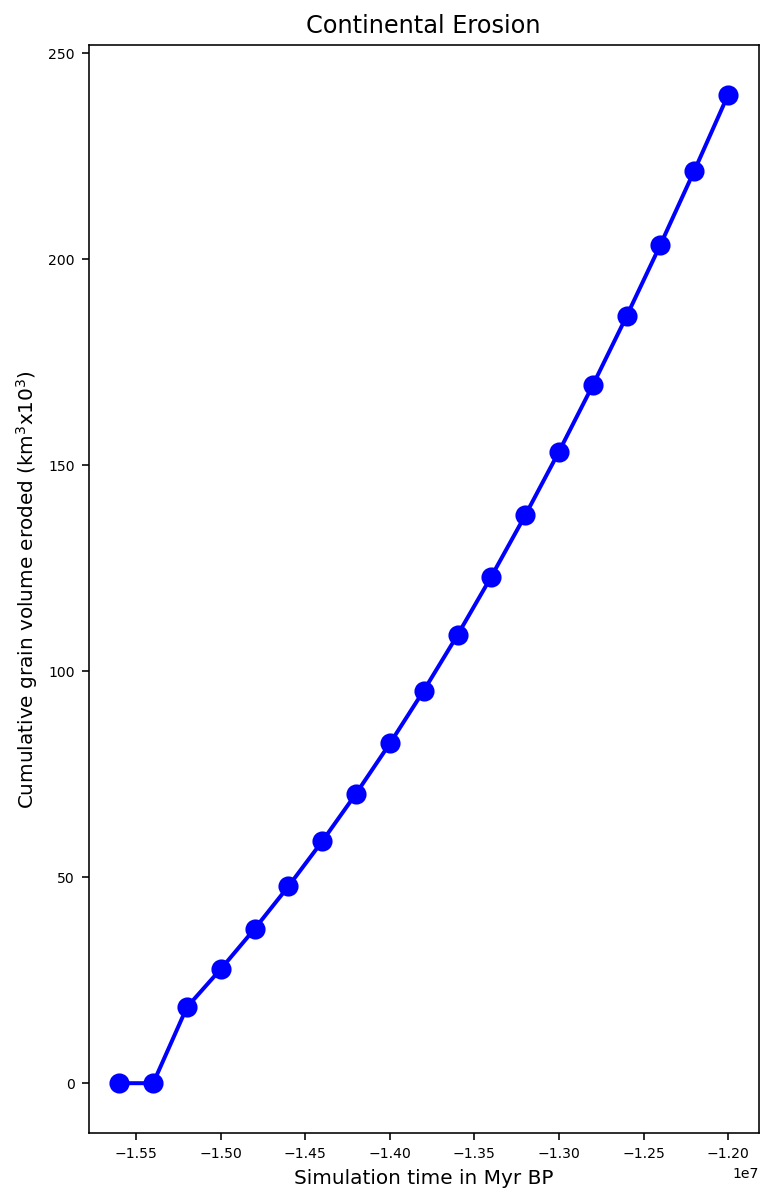

In [87]:
plt.figure(figsize=(6,10))

plt.xlabel('Simulation time in Myr BP')
plt.ylabel('Cumulative grain volume eroded (km$^3$x10$^3$)')
plt.title('Continental Erosion')

# 1k
plt.scatter(times, volero,  s=50,  marker='o', facecolor='b', lw = 3) #, label='dt=1k')
plt.plot(times, volero,'b-',linewidth=2)

# plt.legend(loc=0, fontsize=10)

plt.show()
plt.close()